In [1]:
import pandas as pd
import spacy

In [2]:
labels = ['Quantity', 'Unit', 'Food', 'Variety', 'Preparation', 'Alteration', 'Brand', 'Optional', 'State']

In [3]:
ner_ds = pd.read_json("../data/NER_data/first_test.jsonl", lines=True)

In [4]:
from spacy.tokens import DocBin

nlp = spacy.blank("en")

def doc_from_ds(ds):
    db = DocBin()
    for i, [text, annotations] in ds[['text', 'label']].iterrows():
        try:
            doc = nlp.make_doc(text)
            entities = [doc.char_span(*annotation) for annotation in annotations]
            doc.ents = entities
            db.add(doc)
        except TypeError:
            continue
    return db
    

In [5]:
from sklearn.model_selection import train_test_split
def ds_to_data_split(ds, train_size=0.8, random_state=123):
    train_ds, val_ds = train_test_split(ds, train_size=train_size, random_state=random_state)
    train_bin = doc_from_ds(train_ds)
    val_bin = doc_from_ds(val_ds)

    return train_bin, val_bin

In [6]:
train_bin, val_bin =  ds_to_data_split(ner_ds)
train_path = "../data/NER_data/spacy/test_train.spacy"
val_path = "../data/NER_data/spacy/test_val.spacy"
train_bin.to_disk(train_path)
val_bin.to_disk(val_path)

In [7]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [8]:
import subprocess

def gen_config(train_path: str, dev_path:str, train_log_path: str, out_path: str):
    BASE_CONFIG = f"""[paths]
    train = {train_path}
    dev = {dev_path}
    vectors = null
    [system]
    gpu_allocator = null
    
    [nlp]
    lang = "en"
    pipeline = ["tok2vec","ner"]
    batch_size = 1000
    
    [components]
    
    [components.tok2vec]
    factory = "tok2vec"
    
    [components.tok2vec.model]
    @architectures = "spacy.Tok2Vec.v2"
    
    [components.tok2vec.model.embed]
    @architectures = "spacy.MultiHashEmbed.v2"
    width = ${{components.tok2vec.model.encode.width}}
    attrs = ["NORM", "PREFIX", "SUFFIX", "SHAPE"]
    rows = [5000, 1000, 2500, 2500]
    include_static_vectors = false
    
    [components.tok2vec.model.encode]
    @architectures = "spacy.MaxoutWindowEncoder.v2"
    width = 96
    depth = 4
    window_size = 1
    maxout_pieces = 3
    
    [components.ner]
    factory = "ner"
    
    [components.ner.model]
    @architectures = "spacy.TransitionBasedParser.v2"
    state_type = "ner"
    extra_state_tokens = false
    hidden_width = 64
    maxout_pieces = 2
    use_upper = true
    nO = null
    
    [components.ner.model.tok2vec]
    @architectures = "spacy.Tok2VecListener.v1"
    width = ${{components.tok2vec.model.encode.width}}
    
    [corpora]
    
    [corpora.train]
    @readers = "spacy.Corpus.v1"
    path = ${{paths.train}}
    max_length = 0
    
    [corpora.dev]
    @readers = "spacy.Corpus.v1"
    path = ${{paths.dev}}
    max_length = 0
    
    [training]
    dev_corpus = "corpora.dev"
    train_corpus = "corpora.train"
    
    [training.optimizer]
    @optimizers = "Adam.v1"
    
    [training.batcher]
    @batchers = "spacy.batch_by_words.v1"
    discard_oversize = false
    tolerance = 0.2
    
    [training.batcher.size]
    @schedules = "compounding.v1"
    start = 100
    stop = 1000
    compound = 1.001
    
    [initialize]
    vectors = ${{paths.vectors}}
    
    [training.logger]
    @loggers = "spacy.ConsoleLogger.v3"
    progress_bar = "eval"
    console_output = true
    output_file = {train_log_path}
    """

    with open("temp.cfg", 'w') as f:
      f.write(BASE_CONFIG)
    subprocess.call(['python', '-m', 'spacy', 'init', 'fill-config', 'temp.cfg', out_path])
    os.remove('temp.cfg')

In [9]:
log_path = "train_log.jsonl"
cfg_path = "config.cfg"
gen_config(train_path, val_path, log_path, cfg_path)

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [10]:
import spacy
import mlflow
import mlflow.spacy
from pathlib import Path
import json
from spacy.util import minibatch, compounding
from spacy.cli.train import train

In [11]:
def train_ner(model_dir: Path, config_path: Path):
    train(config_path, model_dir)
    nlp = spacy.load(Path(model_dir) / 'model-best')
    
    mlflow.log_artifact(config_path)
    mlflow.spacy.log_model(spacy_model=nlp, artifact_path="model")
    mlflow.set_tag('model_flavor', 'spacy')
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    return(model_uri)

In [16]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_conf_mat(model_uri: str, val_path: Path):
    nlp = mlflow.spacy.load_model(model_uri=model_uri)
    test_set = list(DocBin().from_disk(val_path).get_docs(nlp.vocab))
    pred_ents = []
    true_ents = []
    
    for recipe in test_set:
      # tok.ent_type_ gets the ent per token, as opposed to breaking the Doc into
      # entities. This ensures that `true_ents` and `pred_ents` are the same length.
      true_ents += [tok.ent_type_ for tok in recipe]
      # `recipe.text` grabs the raw recipe, because `recipe` already contains entity
      # labels.
      pred_ents += [tok.ent_type_ for tok in nlp(recipe.text)]
    # create and display the confusion matrix
    cm = confusion_matrix(true_ents, pred_ents, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    f = disp.plot(xticks_rotation=70).figure_
    mlflow.log_figure(f, 'plots/confusion_matrix.png')

In [13]:
def log_metrics(model_uri: str, train_log_path: Path, val_path: Path):
    mlflow.log_artifact(train_log_path)
    with open(train_log_path) as f:
        for line in f:
            line_data = json.loads(line)
            if line_data['step'] == 0:
                continue
            step = line_data['step']
            for key, value in line_data['losses'].items():
                mlflow.log_metric(f"loss_{key}", value, step)
            for key, value in line_data['scores'].items():
                mlflow.log_metric(f"score_{key}", value, step)
            mlflow.log_metric(f"score", line_data['score'], step)
    plot_conf_mat(model_uri, val_path)

In [14]:
def run_mlflow_pipe(train_path: Path, val_path: Path, model_dir: Path, config_path: Path, train_log_path: Path):
    mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URL"))
    mlflow.set_experiment("jupyter_NER")
    if os.path.exists(train_log_path):
        os.remove(train_log_path)
    with mlflow.start_run(run_name="jupyer_test") as run:
        model_uri = train_ner(model_dir, config_path)
        log_metrics(model_uri, train_log_path, val_path)
    return model_uri

In [15]:
model_uri = run_mlflow_pipe(train_path, val_path, "output_eff/", cfg_path, log_path)

✔ Created output directory: output_eff
ℹ Saving to output directory: output_eff
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
ℹ Saving results to train_log.jsonl
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     71.00   19.12   15.42   25.15    0.19
  5     200        227.93   4537.53   85.97   84.95   87.02    0.86
 11     400        267.95   1010.39   86.00   85.40   86.61    0.86
 20     600        235.09    437.07   86.64   86.46   86.82    0.87
 30     800        187.29    290.13   86.38   85.94   86.82    0.86
 43    1000        212.02    175.74   86.50   87.22   85.80    0.87
 59    1200        190.32    126.20   87.97   87.70   88.24    0.88
 78    1400        1

2025/05/27 11:57:18 WARNING mlflow.spacy: Generating only the spacy flavor for the provided spacy model. This means the model can be loaded back via `mlflow.spacy.load_model`, but cannot be loaded back using pyfunc APIs like `mlflow.pyfunc.load_model` or via the `mlflow models` CLI commands. MLflow will only generate the pyfunc flavor for spacy models containing a pipeline component that is an instance of spacy.pipeline.TextCategorizer.
2025/05/27 11:57:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run jupyer_test at: https://mlflow.local.agefvert.com/#/experiments/466776196716148841/runs/ba482674dca94989acc6daa8d6ad53cf
🧪 View experiment at: https://mlflow.local.agefvert.com/#/experiments/466776196716148841


NameError: name 'out_uri' is not defined

### model_url = "models:/recipe_NER@prod"
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URL"))
mlflow.set_experiment("jupyter_NER")

In [14]:
nlp = mlflow.spacy.load_model(model_uri=model_url)
test_set = list(DocBin().from_disk(val_path).get_docs(nlp.vocab))
pred_ents = []
true_ents = []

for recipe in test_set:
  # tok.ent_type_ gets the ent per token, as opposed to breaking the Doc into
  # entities. This ensures that `true_ents` and `pred_ents` are the same length.
  true_ents += [tok.ent_type_ for tok in recipe]
  # `recipe.text` grabs the raw recipe, because `recipe` already contains entity
  # labels.
  pred_ents += [tok.ent_type_ for tok in nlp(recipe.text)]

/home/naabzer/develop/recipe_tm/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


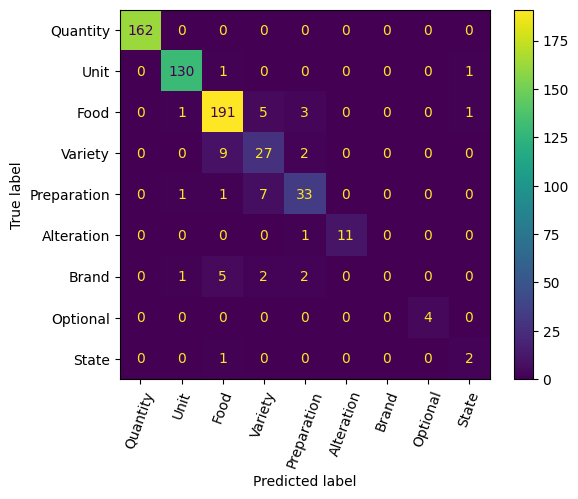

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# create and display the confusion matrix
cm = confusion_matrix(true_ents, pred_ents, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig = disp.plot(xticks_rotation=70)
#fig.figure_.xticks(rotation=70)

### Testing on real data

In [16]:
nlg_ds = pd.read_csv('../data/recipenlg/RecipeNLG_dataset.csv', converters={'ingredients': pd.eval}, nrows=5)


In [17]:
nlg_ds.head()
ingredient_texts = []
for ingredient in nlg_ds['ingredients']:
    ingredient_texts.append(nlp("\n".join(ingredient)))

In [18]:
print(ingredient_texts)

[1 c. firmly packed brown sugar
1/2 c. evaporated milk
1/2 tsp. vanilla
1/2 c. broken nuts (pecans)
2 Tbsp. butter or margarine
3 1/2 c. bite size shredded rice biscuits, 1 small jar chipped beef, cut up
4 boned chicken breasts
1 can cream of mushroom soup
1 carton sour cream, 2 (16 oz.) pkg. frozen corn
1 (8 oz.) pkg. cream cheese, cubed
1/3 c. butter, cubed
1/2 tsp. garlic powder
1/2 tsp. salt
1/4 tsp. pepper, 1 large whole chicken
2 (10 1/2 oz.) cans chicken gravy
1 (10 1/2 oz.) can cream of mushroom soup
1 (6 oz.) box Stove Top stuffing
4 oz. shredded cheese, 1 c. peanut butter
3/4 c. graham cracker crumbs
1 c. melted butter
1 lb. (3 1/2 c.) powdered sugar
1 large pkg. chocolate chips]


In [147]:
from spacy import displacy

In [171]:
displacy.render(ingredient_texts, style='ent')

In [62]:
for text in ingredient_texts:
    i = 0
    for t in text.ents[0:6]:
        if i == 0:
            print(dir(t))
            i = 1
        print(t)
        print(t.label_)
        print(t.start_char)
        print(t.end_char)
        print()
        
    break

['_', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_fix_dep_copy', '_vector', '_vector_norm', 'as_doc', 'char_span', 'conjuncts', 'doc', 'end', 'end_char', 'ent_id', 'ent_id_', 'ents', 'get_extension', 'get_lca_matrix', 'has_extension', 'has_vector', 'id', 'id_', 'kb_id', 'kb_id_', 'label', 'label_', 'lefts', 'lemma_', 'n_lefts', 'n_rights', 'noun_chunks', 'orth_', 'remove_extension', 'rights', 'root', 'sent', 'sentiment', 'sents', 'set_extension', 'similarity', 'start', 'start_char', 'subtree', 'tensor', 'text', 'text_with_ws', 'to_array', 'vector', 'vector_norm', 'vocab']
1
Quantity
0
1

c.
Brand
2
4

brown sugar
Food
19
30

1/2
Quantity
31
34

c.
Unit
35
37

evaporated milk